In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

### Dataset preparation

1. Load the dataset: CIFAR-10 contains 10 classes (e.g airplane, car, bird, cat, deer). The Cats and Dogs contains two classes (cats and dogs).

- Load the dataset using Keras. *DONE*
- Resize all images to 224x224 pixels, and normalize pixel values to [0,1]. *DONE*
-Split the data into training and testing sets. Further slipt the testing set into a testing and validation subsets. Set up data loading for each. *DONE*

In [2]:
# Load and preprocess CIFAR-10 dataset
(img_train, label_train), (img_test, label_test) = cifar10.load_data()

# Limit to the first 5000 images and labels in the training set
img_train = img_train[:5000]
label_train = label_train[:5000]

# Similarly, limit the test set
img_test = img_test[:1000]
label_test = label_test[:1000]

# Resize CIFAR-10 images from 32x32 to 224x224 and normalize pixel values
IMG_SIZE = 224
img_train = tf.image.resize(img_train, (IMG_SIZE, IMG_SIZE)) / 255.0
img_test = tf.image.resize(img_test, (IMG_SIZE, IMG_SIZE)) / 255.0

BATCH_SIZE = 10 # 32
train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train)).batch(BATCH_SIZE).shuffle(100)

# Define dataset size and split ratio
dataset_size = len(list(train_ds))  # Get the total number of samples (5000)
validation_split = 0.2  # 20% for validation
validation_size = int(dataset_size * validation_split) # (1000)

# Split the dataset
val_ds = train_ds.take(validation_size)  # Validation set  # (1000)
train_ds = train_ds.skip(validation_size)  # Training set  # (4000)
test_ds = tf.data.Dataset.from_tensor_slices((img_test, label_test)).batch(BATCH_SIZE) # Test set (1000)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step


### Standard Vision Transformer (ViT) Model.

1. Implement the ViT Model.

  -Load a pretrained Vision Transforme (ViT) model from Hugging Face using the TFVi Model class. *DONE*

  -Add a classification head after the ViT blocks, with 10 output units (one for each class in CIFAR-10), or 1 output unit for the Cats and Dogs problem). *DONE*
  
  -Compile the model with an appropriate optimizer, loss function, and metrics. *DONE*

In [3]:
# Define the Standard Vision Transformer (ViT) Model

# Custom wrapper layer for the ViT model
class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTModelLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        # Adjust dimensions to match the expected input shape for ViT: (batch_size, 3, height, width)
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        # Pass the adjusted input through the ViT model
        vit_output = self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]
        return vit_output

# Define the model creation function
def create_vit_model(num_classes):
    # Load the pretrained Vision Transformer model from Hugging Face
    vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    # Define input layer
    input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Wrap ViT model in the custom layer
    vit_output = ViTModelLayer(vit_model)(input_layer)

    # Add a classification head
    output_layer = layers.Dense(num_classes, activation='softmax')(vit_output)

    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)

    model.summary()

    return model


In [4]:
# Instantiate the ViT model and compile it
num_classes = 10  # CIFAR-10 has 10 classes
vit_model = create_vit_model(num_classes)
vit_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_model_layer (ViTModelLayer)     │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

2. Training

  -Train the model on the training set. *DONE*

  -Save checkpoints periodically, and log training/validation loss and accuracy. *DONE*

In [5]:
# Early stop for save time if if applicable
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    restore_best_weights=True,
    verbose=1
)

In [6]:
# Train the Standard ViT Model
EPOCHS = 5
vit_history = vit_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=EPOCHS,
                            #callbacks=[early_stopping]
                            )

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 157ms/step - accuracy: 0.3019 - loss: 2.1528 - val_accuracy: 0.7700 - val_loss: 1.6709
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step - accuracy: 0.8062 - loss: 1.5400 - val_accuracy: 0.8560 - val_loss: 1.1928
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - accuracy: 0.8647 - loss: 1.1316 - val_accuracy: 0.8700 - val_loss: 0.9331
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - accuracy: 0.8767 - loss: 0.8677 - val_accuracy: 0.8770 - val_loss: 0.7527
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - accuracy: 0.8817 - loss: 0.7224 - val_accuracy: 0.9050 - val_loss: 0.6062


3. Evaluation

  -Evaluate the model on the test set, reporting accuracy and other relevant metrics. *DONE*

  -Plot the training and validation accuracy and loss over epochs. *DONE*
  
  *(I did the plots all together in the last section **Analysis and Comparison**)*

In [7]:
# Evaluate the Standard ViT Model
test_loss, test_accuracy = vit_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.2f}\nTest Accuracy: {test_accuracy:.2f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.8973 - loss: 0.6414
Test Loss: 0.64
Test Accuracy: 0.89


REPORT: The standard ViT model gives good accuracy (90%) and the loss value seems logical when compared to the precision. These results confirm that the model is learning during training.

*(If you want to see the plots, please go to the last section **Analysis and Comparison**)*

### Hybrid VGG16 + ViT Model



1. Pretrained VGG16 for feature Extraction

  -Use pretrained VGG16 layers up to block3_conv3 or up to block5_conv3 to extract initial images features. The advantage of block5_conv3 is that it produces a smaller output (14x14x512) for ViT. *DONE*

  *(I use the predefined block3_conv3 because I got goods results with it)*

  -Freeze these VGG16 layers to use them as a fixed feature extractor. *DONE*

2. Implement the Hybrid Model

  -After extracting features with VGG16, feed the output into the ViT blocks. *DONE*

  -Ensure the output of VGG16 matches the ViT input shape requirements. *DONE*

  -Add a classification head after the ViT blocks to produce predictions. *DONE*

In [8]:
# Define the model creation function
def create_vgg_vit_model(num_classes):
    # ViTConfig() is the configuration class to store the configuration of a ViTModel
    # It is used to instantiate an ViT model according to the specified arguments and model architecture.
    # Link: https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTConfig
    vit_config = ViTConfig()

    # To make it work with hybrid model, you need to change the below three arguments:
    #   image_size: The size (resolution) of each image
    #   num_channels: The number of input channels
    #   patch_size: The size (resolution) of each patch
    # The image_size and num_channels should match the output of VGG16

    vit_config.image_size = 224 # Input size of input for VGG and ViT
    vit_config.num_channels = 3 # RGB

    # Set the patch size to 1, as specified in the original paper (page 5),
    # to handle the intermediate feature maps input
    # Paper link: https://arxiv.org/pdf/2010.11929

    vit_config.patch_size = 16 # I've changed the value of the variable becuase I got memory problems with 1

    # When loading the pretrained model, the configuration Class should be passed via 'config' argument.
    # Also, the 'ignore_mismatched_sizes' should be set to True.

    vit_model = TFViTModel.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        config=vit_config,
        ignore_mismatched_sizes=True,
    )

    # Assemble your hybrid model: VGG16 + ViT
    # ...

    # Import the VGG16 pretrained model
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights = 'imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the VGG16 layers
    for layer in vgg_model.layers:
        layer.trainable = False

    input_layer = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # VGG16
    vgg_output = tf.keras.layers.Flatten()(vgg_model(input_layer)) # Flatten(28,28,512) ->(None,25088)

    # ViT
    vit_output = ViTModelLayer(vit_model)(input_layer) # (None, 768)

    # Concatenate VGG16 Features and ViT Features
    vit_output = tf.keras.layers.Concatenate(axis=-1)([vgg_output, vit_output]) # (None,25088) + (None, 768) = (None, 25856)

    # Add a classification head
    output_layer = layers.Dense(num_classes, activation='softmax')(vit_output)

    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)

    model.summary()

    return model


3. Training and Evaluation

  -Train the hybrid model on the CIFAR-10 or Cats and Dogs training set. *DONE*

  -Evaluate the hybrid model on the test set, tracking the same metrics as in Task 2. *DONE*

  -Save checkpoints and visualize some predictions on test images *DONE*

  

In [9]:
# Instantiate the hybrid model and compile it
num_classes = 10  # CIFAR-10 has 10 classes
hybrid_model = create_vgg_vit_model(num_classes)
hybrid_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vi_t_model_layer_1        │ (None, 768)            │              0 │ input_layer_2[0][0]    │
│ (ViTModelLayer)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 25856)          │              0 │ flatten[0][0],         │
│                           │                        │                │ vi_t_model_layer_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │        258,570 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,973,258 (57.12 MB)

 Trainable params: 258,570 (1010.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Train the hybrid model
EPOCHS = 5
hybrid_history = hybrid_model.fit(train_ds,
                                  validation_data = val_ds,
                                  epochs=EPOCHS,
                                  #callbacks=[early_stopping]
                                  )

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 234ms/step - accuracy: 0.3785 - loss: 1.8926 - val_accuracy: 0.7880 - val_loss: 1.0539
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 221ms/step - accuracy: 0.7893 - loss: 0.9683 - val_accuracy: 0.7950 - val_loss: 0.8265
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 220ms/step - accuracy: 0.8516 - loss: 0.6973 - val_accuracy: 0.8550 - val_loss: 0.6076
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.8850 - loss: 0.5432 - val_accuracy: 0.8650 - val_loss: 0.5307
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.9054 - loss: 0.4458 - val_accuracy: 0.8980 - val_loss: 0.4415


In [11]:
#Evaluate the hybrid model
test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.2f}\nTest Accuracy: {test_accuracy:.2f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.8567 - loss: 0.5104
Test Loss: 0.50
Test Accuracy: 0.86


REPORT: The model shows good performance with a test accuracy of 86% and a moderate loss of 0.51, indicating effective learning but room for slight improvement.

### Analysis and comparation

1. Performance analysis:

  -Compare the performance of the standar ViT and hybrid VGG16 + ViT models.

  -Report quantitative metrics such as accuracy, loss, and training times.

  -Visualize any training or validation differences with relevant plots.

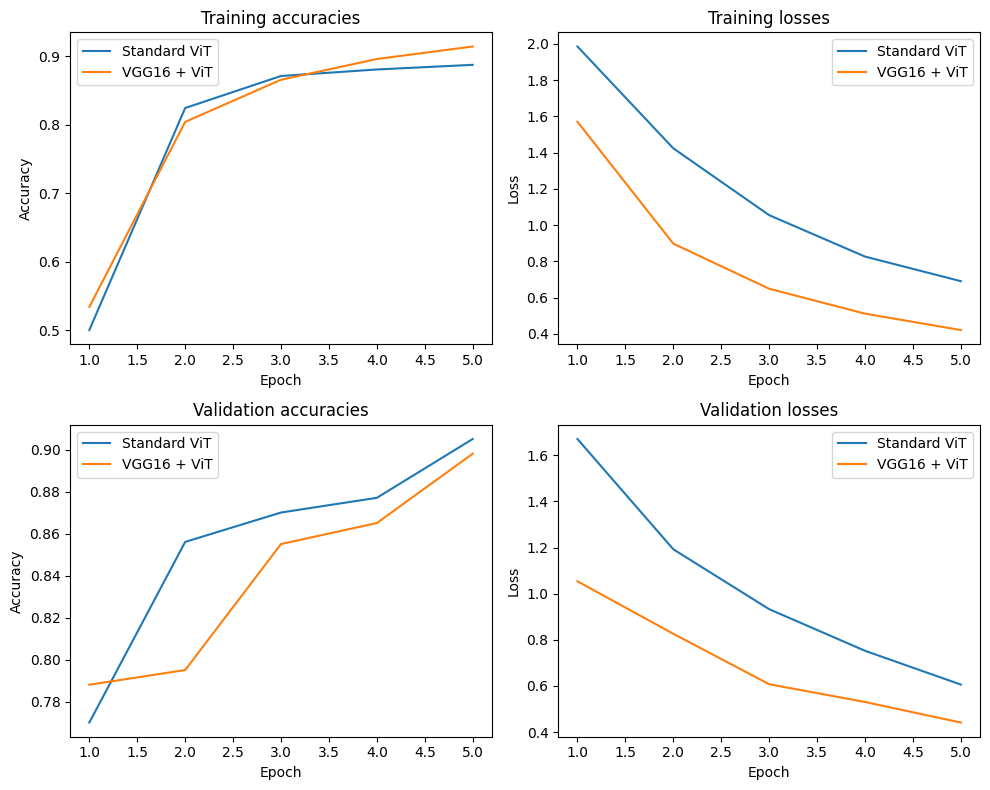

In [15]:
# Plot training and validation curves for both models
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title('Training accuracies')
plt.plot(range(1, 6),vit_history.history['accuracy'],label='Standard ViT')
plt.plot(range(1, 6),hybrid_history.history['accuracy'], label='VGG16 + ViT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Training losses')
plt.plot(range(1, 6),vit_history.history['loss'], label='Standard ViT')
plt.plot(range(1, 6),hybrid_history.history['loss'], label='VGG16 + ViT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.title('Validation accuracies')
plt.plot(range(1, 6),vit_history.history['val_accuracy'], label='Standard ViT')
plt.plot(range(1, 6),hybrid_history.history['val_accuracy'], label='VGG16 + ViT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.title('Validation losses')
plt.plot(range(1, 6),vit_history.history['val_loss'], label='Standard ViT')
plt.plot(range(1, 6),hybrid_history.history['val_loss'], label='VGG16 + ViT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

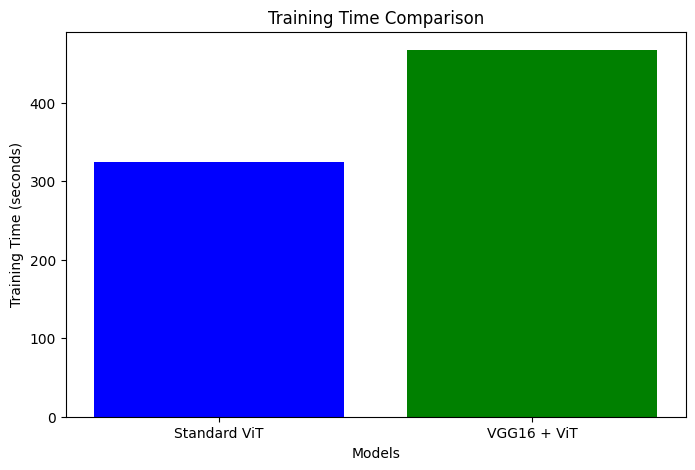

In [17]:
# Example training times (in seconds)
models = ['Standard ViT', 'VGG16 + ViT']
training_times = [325, 467]  # Sum of all epochs for both models

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, training_times, color=['blue', 'green'])
plt.title('Training Time Comparison')
plt.ylabel('Training Time')
plt.xlabel('Models')
plt.show()

REPORT: VGG16 + ViT performs better during training, with faster convergence, lower training loss, and competitive validation accuracy. It benefits from combining local feature extraction (VGG16) with global attention mechanisms (ViT). Meanwhile, Standard ViT shows slightly better generalization (validation accuracy) in the final epoch, indicating robustness in its architecture.

Finally, VGG16 + ViT requires more training time because it involves additional computation from the VGG16 feature extractor, which adds complexity to the model.

2. Discussion

  -Reflect on the performance of each model, describing which model performed better and hypothesize why.


*   Standard ViT is fasterand generalizes better with higher validation accuracy, making it suitable for time-sensitive tasks. VGG16 + ViT achieves better training accuracy and lower loss but requires more time.

  -Discuss trade-off like computational complexity, training time, and memory usage.

*   VGG16 + ViT has higher computational complexity, longer training time, and greater memory usage due to its hybrid architecture, offering richer features but risking overfitting. Standard ViT is faster, more efficient, and generalizes better, making it ideal for resource-constrained tasks.

  -Suggest possible ways to further improve model performance, like data augmentation or fine-tuning additional layers in VGG16.

*   To improve performance, use data augmentation, fine-tune more VGG16 layers, apply dropout to reduce overfitting, and experiment with learning rates or optimizers for better convergence.



